# IBM Data Science Capstone: Finding the Promising Prospective Neighborhoods

## Part 1: Introduction/Business Problem

The target audience for this project is newcomers to a city or those thinking of moving to a city.

The purpose of the project is to help the target audience identify promising neighborhoods where they should focus their housing search.

The user will provide their preferred neighborhood attributes as input, and the model will output a list of neighborhoods most compatible with those preferences.

As a first iteration we limit the city to Portland, Oregon, but ideally we'll expand the model to include any U.S. city or zip code of the user's choosing.

We begin by importing the libraries and packages we will use in the project.

In [1]:
import pandas as pd
import numpy as np


from PIL import Image # converting images into arrays
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot')

!pip install geopy
from geopy.geocoders import Nominatim

!pip install pgeocode
import pgeocode

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans


#!pip install folium  
#import folium 
!pip install folium
import folium



## Part 2: Data Required

The data required will be a list of Portland neighborhoods and their corresponding latitudes and longitudes. We also make use of a geojson file of the neighborhood boundaries for mapping purposes. Both the list of neighborhoods and the geojson file can be downloaded here: http://gis-pdx.opendata.arcgis.com/datasets/neighborhoods-regions. 

Unfortunately, latitudes and longitudes for each neighborhood were not readily available, so those were found through simple web searches and entered into the csv file by hand. As a final note about the data, we actually read two versions of the csv file into a pandas dataframe. One version includes a place holder for our "USER_DEFINED" neighborhood, and for mapping purposes that neighborhood is given a latitude and longitude that place it in the far southeast corner of our map so that it is easy to spot.

Below we read in the two csv files, and we show the tail of the second one, which shows that the "USER_DEFINED" neighborhood has been included.

In [4]:
portland_nbhds= pd.read_csv(r'C:\Users\Jeff\Desktop\Coursera\IBM Data Certificate\Neighborhoods_Regions.csv')
portland_nbhds_with_user= pd.read_csv(r'C:\Users\Jeff\Desktop\Coursera\IBM Data Certificate\Neighborhoods_Regions_with_User.csv')
portland_nbhds_with_user.tail(3)

,OBJECTID,NAME,LAT,LONG
96,97,BRIDGETON,45.6018,-122.6693
97,98,EAST COLUMBIA,45.5908,-122.6522
98,99,USER_DEFINED,45.4334,-122.4970


In the next section we use foursquare to retrieve information about the venues available in each neighborhood. Note that for this part we need to use the dataframe of neighborhoods that does not include the USER_DEFINED neighborhood as it wouldn't make sense to collect venue information there!

# Collecting Venue Information Using Foursquare

First we need to set up our foursquare query where we will be exploring each neighborhood.

## Set up Foursquare query

In [72]:
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 
CLIENT_SECRET:


Below we define the function that will retrieve nearby venues for a neighborhood. The search limit is set to 100 venues per neighborhood, and the radius is set to 600 meters. These settings can be modified by the user if desired. Relevant information for each returned venue is stored as a row in the portland_venues dataframe.

In [6]:
#Get all nearby venues into a dataframe.

LIMIT=100

def getNearbyVenues(names, latitudes, longitudes, radius=600):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

portland_venues = getNearbyVenues(names=portland_nbhds['NAME'],
                                   latitudes=portland_nbhds['LAT'],
                                   longitudes=portland_nbhds['LONG']
                                  )
portland_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,CATHEDRAL PARK,45.5875,-122.7625,Cathedral Park,45.587744,-122.759822,Park
1,CATHEDRAL PARK,45.5875,-122.7625,Occidental Wursthaus,45.588864,-122.761344,German Restaurant
2,CATHEDRAL PARK,45.5875,-122.7625,Occidental Brewing Company,45.588807,-122.761680,Brewery
3,CATHEDRAL PARK,45.5875,-122.7625,Hoplandia Beer,45.589662,-122.755614,Beer Store
4,CATHEDRAL PARK,45.5875,-122.7625,Cathedral Park Restaurant,45.588915,-122.761391,Café


Next we check to see how many unique venue categories there are, and then we get a list of all of them.

This list of categories will be what the user refers to when creating their own list of preferred venues for their neighborhood.

In [7]:
print('There are {} unique categories.'.format(len(portland_venues['Venue Category'].unique())))

There are 293 unique categories.


In [8]:
#Get list of all unique categories:
categories=[]
categories=portland_venues['Venue Category'].unique().tolist()
categories.sort()
categories.remove('Neighborhood')
categories.insert(0,'Neighborhood')
categories

['Neighborhood',
 'ATM',
 'Accessories Store',
 'Adult Boutique',
 'American Restaurant',
 'Amphitheater',
 'Antique Shop',
 'Arcade',
 'Argentinian Restaurant',
 'Art Gallery',
 'Art Museum',
 'Arts & Crafts Store',
 'Arts & Entertainment',
 'Asian Restaurant',
 'Assisted Living',
 'Athletics & Sports',
 'Auto Workshop',
 'Automotive Shop',
 'BBQ Joint',
 'Bagel Shop',
 'Bakery',
 'Bank',
 'Bar',
 'Baseball Field',
 'Basketball Court',
 'Beach',
 'Bed & Breakfast',
 'Beer Bar',
 'Beer Garden',
 'Beer Store',
 'Bike Rental / Bike Share',
 'Bike Shop',
 'Bistro',
 'Board Shop',
 'Boat or Ferry',
 'Bookstore',
 'Botanical Garden',
 'Boutique',
 'Brazilian Restaurant',
 'Breakfast Spot',
 'Brewery',
 'Bubble Tea Shop',
 'Building',
 'Burger Joint',
 'Burrito Place',
 'Bus Line',
 'Bus Station',
 'Bus Stop',
 'Business Service',
 'Butcher',
 'Café',
 'Cajun / Creole Restaurant',
 'Camera Store',
 'Candy Store',
 'Caribbean Restaurant',
 'Casino',
 'Cheese Shop',
 'Chinese Restaurant',
 'Ch

In the cell below, the user should create their own list of preferred venue types. The list can include as many or as few venue types as desired, and the list will be interpreted as an ordered list where the first venue type is the most desirable, the second is next most desirable, and so on. If an error is returned, please check spelling.

In [60]:
#Make a user-defined preference list based on top venue categories.
user_vc=['Bookstore','Coffee Shop','Café','Park','Ice Cream Shop','Hotel']
user_vc

['Bookstore', 'Coffee Shop', 'Café', 'Park', 'Ice Cream Shop', 'Hotel']

The next section generates a dataframe from the user's preference list where each venue is assigned a weight based on the venue's rank in the list. For later comparisons with real neighborhoods, the weights are scaled so that they add to one.

In [61]:
wts=[]

for k in range(len(user_vc)):
    wts.append((len(user_vc)-k)/(.5*(len(user_vc)+1)*len(user_vc)))

pref=[]
for x in categories:
    pref.append(0)
    for y in user_vc:
        if x==y:
            pref[categories.index(x)]=wts[user_vc.index(x)]
            
zipbObj = zip(categories, pref)
 
#Create a dictionary from zip object

pref_dict = dict(zipbObj)
pref_dict['Neighborhood']="USER_DEFINED" #Assign "USER_DEFINED" to 'Neighborhood' key.

user_pref_df=pd.DataFrame.from_dict(pref_dict, orient='index')
pref_df3=user_pref_df.transpose()
pref_df3

,Neighborhood,ATM,Accessories Store,Adult Boutique,American Restaurant,Amphitheater,Antique Shop,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Assisted Living,Athletics & Sports,Auto Workshop,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Bike Rental / Bike Share,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Casino,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Basketball Court,College Bookstore,College Quad,College Soccer Field,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Disc Golf,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Eastern European Restaurant,Electronics Store,Elementary School,Ethiopian Restaurant,Event Service,Event Space,Eye Doctor,Farmers Market,Fast Food Restaurant,Financial or Legal Service,Fish Market,Flea Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Forest,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Heliport,Hill,Historic Site,History Museum,Hobby Shop,Home Service,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Insurance Office,Intersection,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Knitting Store,Korean Restaurant,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Marijuana Dispensary,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Target,Music Store,Music Venue,Nail Salon,New American Restaurant,Night Market,Nightclub,Noodle House,Optical Shop,Organic Grocery,Outdoor Sculpture,Outlet Store,Paper / Office Supplies Store,Park,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Photography Studio,Pie Shop,Pier,Piercing Parlor,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Poke Place,Pool,Pool Hall,Pop-Up Shop,Print Shop,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,Rock Club,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Steakhouse,Storage Facility,Street Food Gathering,Supermarket,Supplement Shop,Sushi Restaurant,Swiss Restaurant,Taco Place,Tanning Salon,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Thrift / Vintage Store,Tiki Bar,Tourist Information Center,Toy / Game Store,Track,Trail,Train Station,Tram Station,Transportation Service,Tunnel,Vegeta

In the next section we take the portland_venues dataframe and create indicator variables out of each venue category. Then we group all venues by neighborhood and find the means for venue type by neighborhood.

In [62]:
#This section creates indicator variables for all of the venue categories, adds 'Neighborhood' column back,
#and moves it to be the first column.

portland_onehot = pd.get_dummies(portland_venues[['Venue Category']], prefix="", prefix_sep="")
portland_onehot['Neighborhood'] = portland_venues['Neighborhood'] 
portland_onehot_nbh=portland_onehot[['Neighborhood']]
portland_onehot.drop(['Neighborhood'],axis=1,inplace=True)
portland_onehot=pd.concat([portland_onehot_nbh,portland_onehot],axis=1)

#Group results by neighborhood and find mean of each type of venue for each neighborhood. 

portland_grouped = portland_onehot.groupby('Neighborhood').mean().reset_index()
portland_grouped.iloc[13:14,:]

,Neighborhood,ATM,Accessories Store,Adult Boutique,American Restaurant,Amphitheater,Antique Shop,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Assisted Living,Athletics & Sports,Auto Workshop,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Bike Rental / Bike Share,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Casino,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Basketball Court,College Bookstore,College Quad,College Soccer Field,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Disc Golf,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Eastern European Restaurant,Electronics Store,Elementary School,Ethiopian Restaurant,Event Service,Event Space,Eye Doctor,Farmers Market,Fast Food Restaurant,Financial or Legal Service,Fish Market,Flea Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Forest,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Heliport,Hill,Historic Site,History Museum,Hobby Shop,Home Service,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Insurance Office,Intersection,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Knitting Store,Korean Restaurant,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Marijuana Dispensary,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Target,Music Store,Music Venue,Nail Salon,New American Restaurant,Night Market,Nightclub,Noodle House,Optical Shop,Organic Grocery,Outdoor Sculpture,Outlet Store,Paper / Office Supplies Store,Park,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Photography Studio,Pie Shop,Pier,Piercing Parlor,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Poke Place,Pool,Pool Hall,Pop-Up Shop,Print Shop,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,Rock Club,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Steakhouse,Storage Facility,Street Food Gathering,Supermarket,Supplement Shop,Sushi Restaurant,Swiss Restaurant,Taco Place,Tanning Salon,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Thrift / Vintage Store,Tiki Bar,Tourist Information Center,Toy / Game Store,Track,Trail,Train Station,Tram Station,Transportation Service,Tunnel,Vegeta

In [63]:
#Here we get an idea of how many venues are in a typical neighborhood.

pgn=portland_onehot.groupby('Neighborhood').sum().reset_index()
pgn2=pgn.sum(axis=1).describe()
pgn2

count     96.000000
mean      23.135417
std       24.558682
min        1.000000
25%        6.000000
50%       15.000000
75%       32.000000
max      100.000000
dtype: float64

To the grouped dataframe we append the dataframe for the USER_DEFINED neighborhood to the bottom. 

In [64]:
#Add the USER_DEFINED neighborhood to the dataframe.
portland_grouped=pd.concat([portland_grouped,pref_df3]).reset_index(drop=True)
portland_grouped.tail()

,Neighborhood,ATM,Accessories Store,Adult Boutique,American Restaurant,Amphitheater,Antique Shop,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Assisted Living,Athletics & Sports,Auto Workshop,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Bike Rental / Bike Share,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Casino,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Basketball Court,College Bookstore,College Quad,College Soccer Field,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Disc Golf,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Eastern European Restaurant,Electronics Store,Elementary School,Ethiopian Restaurant,Event Service,Event Space,Eye Doctor,Farmers Market,Fast Food Restaurant,Financial or Legal Service,Fish Market,Flea Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Forest,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Heliport,Hill,Historic Site,History Museum,Hobby Shop,Home Service,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Insurance Office,Intersection,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Knitting Store,Korean Restaurant,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Marijuana Dispensary,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Target,Music Store,Music Venue,Nail Salon,New American Restaurant,Night Market,Nightclub,Noodle House,Optical Shop,Organic Grocery,Outdoor Sculpture,Outlet Store,Paper / Office Supplies Store,Park,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Photography Studio,Pie Shop,Pier,Piercing Parlor,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Poke Place,Pool,Pool Hall,Pop-Up Shop,Print Shop,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,Rock Club,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Steakhouse,Storage Facility,Street Food Gathering,Supermarket,Supplement Shop,Sushi Restaurant,Swiss Restaurant,Taco Place,Tanning Salon,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Thrift / Vintage Store,Tiki Bar,Tourist Information Center,Toy / Game Store,Track,Trail,Train Station,Tram Station,Transportation Service,Tunnel,Vegeta

Next we retrieve the top venues for each neighborhood. The user can edit the number of top venues that is reported.

In [65]:
#Define the function we'll call for each neighbrohood that will return the top X venues.
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

#This section records the top venues for each neighborhood in order of popularity. The parameter specifying how 
#many venues to report can be changed below in 'num_top_venues'.

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = portland_grouped['Neighborhood']

for ind in np.arange(portland_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(portland_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.tail(3)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
94,WOODLAWN,Brewery,Pizza Place,Grocery Store,Mexican Restaurant,Bus Stop,Market,Marijuana Dispensary,Park,Coffee Shop,Italian Restaurant
95,WOODSTOCK,Breakfast Spot,Thrift / Vintage Store,Convenience Store,Pizza Place,Dive Bar,Sandwich Place,Grocery Store,Thai Restaurant,Bus Stop,Flea Market
96,USER_DEFINED,Bookstore,Coffee Shop,Café,Park,Ice Cream Shop,Hotel,Eye Doctor,Elementary School,Ethiopian Restaurant,Event Service


# Segmenting Neighborhoods

In this section we use k-means clustering to group neighborhoods by similarity of venues present. It is important to note that we send the USER_DEFINED neighborhood to the algorithm as well so that the algorithm returns a group of neighborhoods it considers to be *most similar to the user's preferences*.

The number of clusters is stored in the parameter 'kclusters,' which can be modified by the user. Data is standardized before being sent to the clustering algorithm. Our initial choice of "7" is made based on the inertia graph below, which displays an "elbow" at K=7.

In [66]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

portland_grouped_clustering = portland_grouped.drop('Neighborhood', 1)

portland_grouped_clustering = preprocessing.StandardScaler().fit(portland_grouped_clustering).transform(portland_grouped_clustering.astype(float))

kclusters = 7



kmeans = KMeans(n_clusters=kclusters, random_state=0, init='k-means++').fit(portland_grouped_clustering)

kmeans.labels_[0:10], kmeans.inertia_

(array([4, 4, 0, 4, 4, 2, 4, 4, 4, 0]), 24820.262475040832)

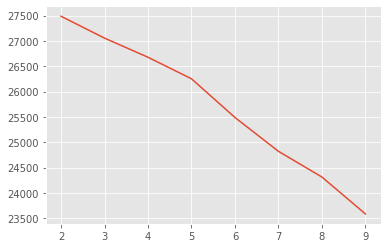

In [67]:
#Find inertia over k:
inertia_k=[]
x_k=[]
for k in range(2,10):
    kclusters1 = k
    x_k.append(k)
    portland_grouped_clustering1 = portland_grouped.drop('Neighborhood', 1)
    portland_grouped_clustering1 = preprocessing.StandardScaler().fit(portland_grouped_clustering1).transform(portland_grouped_clustering1.astype(float))

    kmeans1 = KMeans(n_clusters=kclusters1, random_state=0, init='k-means++').fit(portland_grouped_clustering1)

    inertia_k.append(kmeans1.inertia_)
inertia_k, x_k
plt.plot(x_k,inertia_k)

Next we add the cluster labels to our dataframe, and we merge the results with the dataframe of neighborhoods, latitudes, and longitudes.

In [68]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

portland_merged = portland_nbhds_with_user

portland_merged = portland_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='NAME')

#We make sure to drop any neighborhoods that did not receive a label.

portland_merged.dropna(inplace=True)
portland_merged['Cluster Labels'] = portland_merged['Cluster Labels'].astype(np.int64)
portland_merged.tail()

,OBJECTID,NAME,LAT,LONG,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
94,95,PORTSMOUTH,45.5855,-122.7181,4,Pizza Place,Convenience Store,Mexican Restaurant,Park,Breakfast Spot,Deli / Bodega,Bar,Chinese Restaurant,Beer Bar,Gym / Fitness Center
95,96,HAYDEN ISLAND NEIGHBORHOOD NETWORK,45.6224,-122.7018,4,Beach,Zoo Exhibit,Eastern European Restaurant,Elementary School,Ethiopian Restaurant,Event Service,Event Space,Eye Doctor,Farmers Market,Fast Food Restaurant
96,97,BRIDGETON,45.6018,-122.6693,4,American Restaurant,Harbor / Marina,Dog Run,Bar,General Travel,Pizza Place,Motel,Hawaiian Restaurant,Deli / Bodega,Sandwich Place
97,98,EAST COLUMBIA,45.5908,-122.6522,4,Park,Drugstore,Dry Cleaner,Eastern European Restaurant,Electronics Store,Elementary School,Ethiopian Restaurant,Event Service,Event Space,Zoo Exhibit
98,99,USER_DEFINED,45.4334,-122.4970,0,Bookstore,Coffee Shop,Café,Park,Ice Cream Shop,Hotel,Eye Doctor,Elementary School,Ethiopian Restaurant,Event Service


# Mapping the Clusters

In this section we create a folium map of all portland neighborhoods, including the USER_DEFINED neighborhood, color coded by cluster. We also include a layer that can be unselected for the neighborhood boundaries.

First we use a geocoder to retrieve the latitude and longitude of Portland, Oregon, for the map.

In [69]:
address = 'Portland, Oregon'

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geographical coordinates of Portland are {}, {}.'.format(latitude, longitude))

The geographical coordinates of Portland are 45.5202471, -122.6741949.


The map below is color coded to show the clusters of neighborhoods. The 'USER_DEFINED' neighborhood is plotted by itself in the southeast corner, and the user can click on its marker to the cluster to which it belongs.

In [70]:
url = 'https://opendata.arcgis.com/datasets/'
portland_nbhds_geo = f'{url}/9f50a605cf4945259b983fa35c993fe9_125.geojson'

map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, cluster in zip(portland_merged['LAT'], portland_merged['LONG'], portland_merged['NAME'], portland_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
    
folium.GeoJson(
    portland_nbhds_geo,
    name='geojson'
).add_to(map_clusters)

folium.LayerControl().add_to(map_clusters)

map_clusters

## Viewing the User's Most Promising Neighborhoods

This section outputs all of the neighborhoods in the cluster to which the user's neighborhood belongs.

In [71]:
portland_merged.loc[portland_merged['Cluster Labels'] == portland_merged['Cluster Labels'][98], portland_merged.columns[[1] + list(range(5, portland_merged.shape[1]))]]

,NAME,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,SUMNER ASSOCIATION OF NEIGHBORS,Coffee Shop,Hotel,Business Service,Furniture / Home Store,Eye Doctor,Electronics Store,Elementary School,Ethiopian Restaurant,Event Service,Event Space
41,MULTNOMAH,Coffee Shop,Café,Music Store,Sports Bar,Thai Restaurant,Bookstore,Bar,Jewelry Store,Bakery,Toy / Game Store
42,BRENTWOOD-DARLINGTON,Trail,Dog Run,Park,Ice Cream Shop,Deli / Bodega,Night Market,Zoo Exhibit,Event Space,Elementary School,Ethiopian Restaurant
59,ARDENWALD-JOHNSON CREEK,Furniture / Home Store,Park,Café,Grocery Store,Coffee Shop,Dry Cleaner,Electronics Store,Elementary School,Ethiopian Restaurant,Event Service
79,ELIOT,Brewery,Dive Bar,Lounge,Coffee Shop,Sporting Goods Shop,Bookstore,Café,Ethiopian Restaurant,Tapas Restaurant,Nightclub
98,USER_DEFINED,Bookstore,Coffee Shop,Café,Park,Ice Cream Shop,Hotel,Eye Doctor,Elementary School,Ethiopian Restaurant,Event Service


## Discussion

The presence of such a large cluster is a common occurrence and problematic. In this example, however, the user neighborhood is placed in a cluster of useful size. Based on the top ten venues present in each neighborhood in the user's cluster, the neighborhoods appear to be very dissimilar.